# Focal Loss with MobileNetV2 SSD

Github repo:
https://github.com/FurkanOM/tf-ssd/tree/master

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import datetime
import os
import pathlib
import argparse

2024-03-23 15:50:19.164243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 15:50:19.164364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 15:50:19.293092: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# anchor_utils

In [2]:
"""Generate Anchor Boxes.
"""

def get_scale_for_nth_feature_map(k, m=6, scale_min=0.2, scale_max=0.9):
    """Calculating scale value for nth feature map using the given method in the paper.
    inputs:
        k = nth feature map for scale calculation
        m = length of all using feature maps for detections, 6 for ssd300

    outputs:
        scale = calculated scale value for given index
    """
    # [0.2, 0.34, 0.48, 0.62, 0.76, 0.9, 1.04]
    return scale_min + ((scale_max - scale_min) / (m - 1)) * (k - 1)

def generate_base_prior_boxes(aspect_ratios, feature_map_index, total_feature_map, hyper_params):
    """Generating top left prior boxes for given stride, height and width pairs of different aspect ratios.
    These prior boxes same with the anchors in Faster-RCNN.
    inputs:
        aspect_ratios = for all feature map shapes + 1 for ratio 1
        feature_map_index = nth feature maps for scale calculation
        total_feature_map = length of all using feature map for detections, 6 for ssd300

    outputs:
        base_prior_boxes = (prior_box_count, [y1, x1, y2, x2])
    """
    # print(feature_map_index)
    if hyper_params["use_custom_scale"]:    
        current_scale = hyper_params["scale"][feature_map_index-1]
        next_scale = hyper_params["scale"][feature_map_index]
    else:
        current_scale = get_scale_for_nth_feature_map(feature_map_index, m=total_feature_map, 
                                                      scale_min=hyper_params["scale_min"], scale_max=hyper_params["scale_max"])
        next_scale = get_scale_for_nth_feature_map(feature_map_index + 1, m=total_feature_map, 
                                                   scale_min=hyper_params["scale_min"], scale_max=hyper_params["scale_max"])
    print(current_scale, next_scale)
    base_prior_boxes = []
    for aspect_ratio in aspect_ratios:
        height = current_scale / tf.sqrt(aspect_ratio)
        width = current_scale * tf.sqrt(aspect_ratio)
        base_prior_boxes.append([-height/2, -width/2, height/2, width/2])
#         print(height, width)
    # 1 extra pair for ratio 1
    height = width = tf.sqrt(current_scale * next_scale)
#     print(height, width)
    base_prior_boxes.append([-height/2, -width/2, height/2, width/2])
    return tf.cast(base_prior_boxes, dtype=tf.float32)

def generate_prior_boxes(feature_map_shapes, aspect_ratios, hyper_params):
    """Generating top left prior boxes for given stride, height and width pairs of different aspect ratios.
    These prior boxes same with the anchors in Faster-RCNN.
    Aspect ratio is the width to height ratio.
    inputs:
        feature_map_shapes = for all feature map output size
        aspect_ratios = for all feature map shapes + 1 for ratio 1

    outputs:
        prior_boxes = (total_prior_boxes, [y1, x1, y2, x2])
            these values in normalized format between [0, 1]
    """
    prior_boxes = []
    for i, feature_map_shape in enumerate(feature_map_shapes):
        print(feature_map_shape)
        base_prior_boxes = generate_base_prior_boxes(aspect_ratios[i], i+1, len(feature_map_shapes), hyper_params)
        print(base_prior_boxes)

        stride = 1 / feature_map_shape
        # Create linearly spaced arrays of x and y coordinates
        grid_coords = tf.cast(tf.range(0, feature_map_shape) / feature_map_shape + stride / 2, dtype=tf.float32)
        grid_x, grid_y = tf.meshgrid(grid_coords, grid_coords)
        flat_grid_x, flat_grid_y = tf.reshape(grid_x, (-1, )), tf.reshape(grid_y, (-1, ))

        grid_map = tf.stack([flat_grid_y, flat_grid_x, flat_grid_y, flat_grid_x], -1)

        prior_boxes_for_feature_map = tf.reshape(base_prior_boxes, (1, -1, 4)) + tf.reshape(grid_map, (-1, 1, 4))
        prior_boxes_for_feature_map = tf.reshape(prior_boxes_for_feature_map, (-1, 4))
        prior_boxes.append(prior_boxes_for_feature_map)
        
    prior_boxes = tf.concat(prior_boxes, axis=0)
    # print(prior_boxes)
    return tf.clip_by_value(prior_boxes, 0, 1)

# parameters

In [3]:
backbone = "mobilenet_v2"

In [4]:
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# base_model = MobileNetV2(include_top=False, input_shape=(640, 640, 3))
# base_model.summary()

In [5]:
SSD = {
#     "mobilenet_v2": {
#         "img_size": 1024,
#         "feature_map_shapes": [128,64,32,16,8,4],
#         "aspect_ratios": [[1., 2., 1./2., 5., 1./5.],
#                           [1., 2., 1./2., 5., 1./5.],
#                           [1., 2., 1./2., 5., 1./5.],
#                           [1., 2., 1./2., 5., 1./5.],
#                           [1., 2., 1./2., 5., 1./5.],
#                           [1., 2., 1./2., 5., 1./5.]],
#         "use_custom_scale": False,
#         "scale_min": 0.05,
#         "scale_max": 0.5,
#         "scale": [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.2],
#         "trainable": True,
#         "num_trainable": None
#     },
    "mobilenet_v2": {
        "img_size": 640,
        "feature_map_shapes": [80, 40, 20, 10, 5, 3],
        "aspect_ratios": [[1., 2., 1./2., 5., 1./5.],
                          [1., 2., 1./2., 5., 1./5.],
                          [1., 2., 1./2., 5., 1./5.],
                          [1., 2., 1./2., 5., 1./5.],
                          [1., 2., 1./2., 5., 1./5.],
                          [1., 2., 1./2., 5., 1./5.]],
        "use_custom_scale": False,
        "scale_min": 0.05,
        "scale_max": 0.5,
        "scale": [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.2],
        "trainable": True,
        "num_trainable": None
    },
#     "mobilenet_v2": {
#         "img_size": 300,
#         "feature_map_shapes": [38, 19, 10, 5, 3, 2],
#         "aspect_ratios": [[1., 2., 1./2., 5., 1./5.],
#                           [1., 2., 1./2., 5., 1./5.],
#                           [1., 2., 1./2., 5., 1./5.],
#                           [1., 2., 1./2., 5., 1./5.],
#                           [1., 2., 1./2., 5., 1./5.],
#                           [1., 2., 1./2., 5., 1./5.]],
#         "use_custom_scale": False,
#         "scale_min": 0.05,
#         "scale_max": 0.5,
#         "scale": [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.2],
#         "trainable": True,
#         "num_trainable": None
#     },
}

def get_hyper_params(backbone, **kwargs):
    """Generating hyper params in a dynamic way.
    inputs:
        **kwargs = any value could be updated in the hyper_params

    outputs:
        hyper_params = dictionary
    """
    hyper_params = SSD[backbone]
    hyper_params["detection"] = None # None / "FPN" / "BiFPN" / "PAFPN" / "NASFPN"
    hyper_params["feature_fusion"] = None # 
    hyper_params["dataset"] = 0 # dut, tilda, daffodil, thesis, combined
    hyper_params["iou_threshold"] = 0.5
    hyper_params["neg_pos_ratio"] = 3 # neg:pos 3:1 ratio
    hyper_params["loc_loss_alpha"] = 1 # weight for the localization loss
    hyper_params["variances"] = [0.1, 0.1, 0.2, 0.2]
    hyper_params["use_focal"] = True
    hyper_params["alpha"] = [0.25, 2, 2, 2, 2]
    hyper_params["gamma"] = 1.0
    hyper_params["batch_size"] = 8
    hyper_params["epochs"] = 200
    hyper_params["lr"] = 1e-3
    hyper_params["patience"] = 20
    # overwrite any parameters
    for key, value in kwargs.items():
        if key in hyper_params and value:
            hyper_params[key] = value

    return hyper_params

hyper_params = get_hyper_params(backbone)
display(hyper_params)

# We calculate prior boxes for one time and use it for all operations because of the all images are the same sizes
prior_boxes = generate_prior_boxes(hyper_params["feature_map_shapes"], hyper_params["aspect_ratios"], hyper_params)
display(prior_boxes)

{'img_size': 640,
 'feature_map_shapes': [80, 40, 20, 10, 5, 3],
 'aspect_ratios': [[1.0, 2.0, 0.5, 5.0, 0.2],
  [1.0, 2.0, 0.5, 5.0, 0.2],
  [1.0, 2.0, 0.5, 5.0, 0.2],
  [1.0, 2.0, 0.5, 5.0, 0.2],
  [1.0, 2.0, 0.5, 5.0, 0.2],
  [1.0, 2.0, 0.5, 5.0, 0.2]],
 'use_custom_scale': False,
 'scale_min': 0.05,
 'scale_max': 0.5,
 'scale': [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.2],
 'trainable': True,
 'num_trainable': None,
 'detection': None,
 'feature_fusion': None,
 'dataset': 0,
 'iou_threshold': 0.5,
 'neg_pos_ratio': 3,
 'loc_loss_alpha': 1,
 'variances': [0.1, 0.1, 0.2, 0.2],
 'use_focal': True,
 'alpha': [0.25, 2, 2, 2, 2],
 'gamma': 1.0,
 'batch_size': 8,
 'epochs': 200,
 'lr': 0.001,
 'patience': 20}

80
0.05 0.14
tf.Tensor(
[[-0.025      -0.025       0.025       0.025     ]
 [-0.01767767 -0.03535534  0.01767767  0.03535534]
 [-0.03535534 -0.01767767  0.03535534  0.01767767]
 [-0.01118034 -0.0559017   0.01118034  0.0559017 ]
 [-0.0559017  -0.01118034  0.0559017   0.01118034]
 [-0.041833   -0.041833    0.041833    0.041833  ]], shape=(6, 4), dtype=float32)
40
0.14 0.22999999999999998
tf.Tensor(
[[-0.07       -0.07        0.07        0.07      ]
 [-0.04949747 -0.09899495  0.04949747  0.09899495]
 [-0.09899495 -0.04949747  0.09899495  0.04949747]
 [-0.03130496 -0.15652475  0.03130496  0.15652475]
 [-0.15652476 -0.03130495  0.15652476  0.03130495]
 [-0.0897218  -0.0897218   0.0897218   0.0897218 ]], shape=(6, 4), dtype=float32)
20
0.22999999999999998 0.32
tf.Tensor(
[[-0.115      -0.115       0.115       0.115     ]
 [-0.08131728 -0.16263457  0.08131728  0.16263457]
 [-0.16263457 -0.08131728  0.16263457  0.08131728]
 [-0.05142957 -0.2571478   0.05142957  0.2571478 ]
 [-0.25714782 -0.051

<tf.Tensor: shape=(51204, 4), dtype=float32, numpy=
array([[0.        , 0.        , 0.03125   , 0.03125   ],
       [0.        , 0.        , 0.02392767, 0.04160534],
       [0.        , 0.        , 0.04160534, 0.02392767],
       ...,
       [0.7215299 , 0.27431637, 0.9451367 , 1.        ],
       [0.2743163 , 0.7215299 , 1.        , 0.9451367 ],
       [0.5617638 , 0.5617638 , 1.        , 1.        ]], dtype=float32)>

In [6]:
# Sanity Check 
assert isinstance(hyper_params["dataset"], int) and -1 < hyper_params["dataset"] < 5

# MobileNetV2 SSD

Specified backbone

In [7]:
def conv_layer(filter, kernel_size,
               layer, strides=1,
               padding='same',
               activation='linear',
               name='conv2d',pool=False,
               poolsize=2,poolstride=2,conv=True):
    if conv == True:
        layer = tf.keras.layers.Conv2D(filters=filter,
                                    kernel_size=kernel_size,
                                    strides=strides,
                                    activation=activation,
                                    padding=padding,
                                    name=name,
                                    kernel_initializer='he_normal')(layer)
        layer = tf.keras.layers.BatchNormalization()(layer)
        layer = tf.keras.layers.ReLU()(layer)
    elif pool == True:
        layer=tf.keras.layers.MaxPool2D(pool_size=(poolsize, poolsize),
                                        strides=poolstride, padding='same')(layer)
    return layer

In [8]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model

def get_model(hyper_params):
    """Generating ssd model for hyper params.
    inputs:
        hyper_params = dictionary

    outputs:
        ssd_model = tf.keras.model
    """
    img_size = hyper_params["img_size"]
    num_classes = hyper_params["total_labels"]
    base_model = MobileNetV2(include_top=False, input_shape=(img_size, img_size, 3))
    
    if hyper_params["trainable"]:
        base_model.trainable = True
        if hyper_params["num_trainable"] != None:
            for layer in base_model.layers[:-hyper_params["num_trainable"]]:
                layer.trainable = False
    else: base_model.trainable = False

    input = base_model.input

#     extra_conv = base_model.get_layer("block_3_expand_relu").output 
    zero_conv = base_model.get_layer("block_6_expand_relu").output 
    first_conv = base_model.get_layer("block_13_expand_relu").output
    second_conv = base_model.output # 32x32x1280
    
    # first_conv = base_model.get_layer("block_13_expand_relu").output # 19 x 19 x 576
    # second_conv = base_model.output # 10 x 10 x 1280
    
    ############################ Extra Feature Layers Start ############################
    extra1_1 = conv_layer(256, (1, 1), strides=(1, 1), padding="valid", activation="relu", name="extra1_1", layer=second_conv)
    extra1_2 = conv_layer(512, (3, 3), strides=(2, 2), padding="same", activation="relu", name="extra1_2", layer=extra1_1)

    extra2_1 = conv_layer(128, (1, 1), strides=(1, 1), padding="valid", activation="relu", name="extra2_1", layer=extra1_2)
    extra2_2 = conv_layer(256, (3, 3), strides=(2, 2), padding="same", activation="relu", name="extra2_2", layer=extra2_1)

    extra3_1 = conv_layer(128, (1, 1), strides=(1, 1), padding="valid", activation="relu", name="extra3_1", layer=extra2_2)
    extra3_2 = conv_layer(256, (3, 3), strides=(2, 2), padding="same", activation="relu", name="extra3_2", layer=extra3_1)
    
#     extra4_1 = conv_layer(128, (1, 1), strides=(1, 1), padding="valid", activation="relu", name="extra4_1", layer=extra3_2)
#     extra4_2 = conv_layer(256, (3, 3), strides=(2, 2), padding="same", activation="relu", name="extra4_2", layer=extra4_1)
    ############################ Extra Feature Layers End ############################
    
#     pred_deltas, pred_labels = get_head_from_outputs(hyper_params, [extra_conv, zero_conv, first_conv, second_conv, extra1_2, extra2_2, extra3_2])
    pred_deltas, pred_labels = get_head_from_outputs(hyper_params, [zero_conv, first_conv, second_conv, extra1_2, extra2_2, extra3_2])
    return Model(inputs=input, outputs=[pred_deltas, pred_labels])

def init_model(model, img_size):
    """Initializing model with dummy data for load weights with optimizer state and also graph construction.
    inputs:
        model = tf.keras.model

    """
    model(tf.random.uniform((1, img_size, img_size, 3)))

# Roboflow Setup

In [9]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YOUR API KEY")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 34.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.1
  Attempting uninstall: certifi
    Found existing installation: certifi 2023.11.17
  

In [10]:
os.chdir('/kaggle/working/')
if hyper_params["dataset"] == 0:
    # dut
    project = rf.workspace("ducks-zdbul").project("fabric-defect-capstone")
    dataset = project.version(1).download("tfrecord")
elif hyper_params["dataset"] == 1:
    # tilda
    project = rf.workspace("irvin-andersen").project("tilda-fabric")
    dataset = project.version(2).download("tfrecord")
elif hyper_params["dataset"] == 2:
    # daffodil
    project = rf.workspace("defect-detection-witqu").project("fabric-defect-daffodil")
    dataset = project.version(1).download("tfrecord")
elif hyper_params["dataset"] == 3:
    # thesis
    project = rf.workspace("ducks-zdbul").project("fabric-defect-thesis-quv7v")
    dataset = project.version(1).download("tfrecord")
elif hyper_params["dataset"] == 4:
    pass

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fabric-Defect-Capstone-1 in tfrecord:: 100%|██████████| 11/11 [00:01<00:00,  8.11it/s]


# Utils

# augmentation

In [11]:
def apply(img, gt_boxes):
    """Randomly applying data augmentation methods to image and ground truth boxes.
    inputs:
        img = (height, width, depth)
        gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
            in normalized form [0, 1]
    outputs:
        modified_img = (final_height, final_width, depth)
        modified_gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
            in normalized form [0, 1]
    """
    # Color operations
    # Randomly change hue, saturation, brightness and contrast of image
    color_methods = [random_brightness, random_contrast, random_hue, random_saturation]
    # Geometric operations
    # Randomly sample a patch and flip horizontally image and ground truth boxes
    geometric_methods = [patch, flip_horizontally]

    for augmentation_method in geometric_methods + color_methods:
        img, gt_boxes = randomly_apply_operation(augmentation_method, img, gt_boxes)

    img = tf.clip_by_value(img, 0, 1)
    return img, gt_boxes

def get_random_bool():
    """Generating random boolean.
    outputs:
        random boolean 0d tensor
    """
    return tf.greater(tf.random.uniform((), dtype=tf.float32), 0.5)

def randomly_apply_operation(operation, img, gt_boxes, *args):
    """Randomly applying given method to image and ground truth boxes.
    inputs:
        operation = callable method
        img = (height, width, depth)
        gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
    outputs:
        modified_or_not_img = (final_height, final_width, depth)
        modified_or_not_gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
    """
    return tf.cond(
        get_random_bool(),
        lambda: operation(img, gt_boxes, *args),
        lambda: (img, gt_boxes)
    )

def random_brightness(img, gt_boxes, max_delta=0.12):
    """Randomly change brightness of the image.
    inputs:
        img = (height, width, depth)
        gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
    outputs:
        modified_img = (height, width, depth)
        gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
    """
    return tf.image.random_brightness(img, max_delta), gt_boxes

def random_contrast(img, gt_boxes, lower=0.5, upper=1.5):
    """Randomly change contrast of the image.
    inputs:
        img = (height, width, depth)
        gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
    outputs:
        modified_img = (height, width, depth)
        gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
    """
    return tf.image.random_contrast(img, lower, upper), gt_boxes

def random_hue(img, gt_boxes, max_delta=0.08):
    """Randomly change hue of the image.
    inputs:
        img = (height, width, depth)
        gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
    outputs:
        modified_img = (height, width, depth)
        gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
    """
    return tf.image.random_hue(img, max_delta), gt_boxes

def random_saturation(img, gt_boxes, lower=0.5, upper=1.5):
    """Randomly change saturation of the image.
    inputs:
        img = (height, width, depth)
        gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
    outputs:
        modified_img = (height, width, depth)
        gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
    """
    return tf.image.random_saturation(img, lower, upper), gt_boxes

def flip_horizontally(img, gt_boxes):
    """Flip image horizontally and adjust the ground truth boxes.
    inputs:
        img = (height, width, depth)
        gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
    outputs:
        modified_img = (height, width, depth)
        modified_gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
    """
    flipped_img = tf.image.flip_left_right(img)
    flipped_gt_boxes = tf.stack([gt_boxes[..., 0],
                                1.0 - gt_boxes[..., 3],
                                gt_boxes[..., 2],
                                1.0 - gt_boxes[..., 1]], -1)
    return flipped_img, flipped_gt_boxes

##############################################################################
## Sample patch start
##############################################################################

def get_random_min_overlap():
    """Generating random minimum overlap value.
    outputs:
        min_overlap = random minimum overlap value 0d tensor
    """
    overlaps = tf.constant([0.1, 0.3, 0.5, 0.7, 0.9], dtype=tf.float32)
    i = tf.random.uniform((), minval=0, maxval=tf.shape(overlaps)[0], dtype=tf.int32)
    return overlaps[i]

def expand_image(img, gt_boxes, height, width):
    """Randomly expanding image and adjusting ground truth object coordinates.
    inputs:
        img = (height, width, depth)
        gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
        height = height of the image
        width = width of the image
    outputs:
        img = (final_height, final_width, depth)
        modified_gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
        final_height = final height of the image
        final_width = final width of the image
    """
    expansion_ratio = tf.random.uniform((), minval=1, maxval=4, dtype=tf.float32)
    final_height, final_width = tf.round(height * expansion_ratio), tf.round(width * expansion_ratio)
    pad_left = tf.round(tf.random.uniform((), minval=0, maxval=final_width - width, dtype=tf.float32))
    pad_top = tf.round(tf.random.uniform((), minval=0, maxval=final_height - height, dtype=tf.float32))
    pad_right = final_width - (width + pad_left)
    pad_bottom = final_height - (height + pad_top)

    mean, _ = tf.nn.moments(img, [0, 1])
    expanded_image = tf.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right), (0,0)), constant_values=-1)
    expanded_image = tf.where(expanded_image == -1, mean, expanded_image)

    min_max = tf.stack([-pad_top, -pad_left, pad_bottom+height, pad_right+width], -1) / [height, width, height, width]
    modified_gt_boxes = renormalize_bboxes_with_min_max(gt_boxes, min_max)

    return expanded_image, modified_gt_boxes

def patch(img, gt_boxes):
    """Generating random patch and adjusting image and ground truth objects to this patch.
    After this operation some of the ground truth boxes / objects could be removed from the image.
    However, these objects are not excluded from the output, only the coordinates are changed as zero.
    inputs:
        img = (height, width, depth)
        gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
            in normalized form [0, 1]
    outputs:
        modified_img = (final_height, final_width, depth)
        modified_gt_boxes = (ground_truth_object_count, [y1, x1, y2, x2])
            in normalized form [0, 1]
    """
    img_shape = tf.cast(tf.shape(img), dtype=tf.float32)
    org_height, org_width = img_shape[0], img_shape[1]
    # Randomly expand image and adjust bounding boxes
    img, gt_boxes = randomly_apply_operation(expand_image, img, gt_boxes, org_height, org_width)
    # Get random minimum overlap value
    min_overlap = get_random_min_overlap()

    begin, size, new_boundaries = tf.image.sample_distorted_bounding_box(
        tf.shape(img),
        # use_image_if_no_bounding_boxes=True, ### FIX:26/1/24
        bounding_boxes=tf.expand_dims(gt_boxes, 0),
        aspect_ratio_range=[0.5, 2.0],
        min_object_covered=min_overlap)

    img = tf.slice(img, begin, size)
    img = tf.image.resize(img, (org_height, org_width))
    gt_boxes = renormalize_bboxes_with_min_max(gt_boxes, new_boundaries[0, 0])

    return img, gt_boxes

# bbox_utils

In [12]:
def non_max_suppression(pred_bboxes, pred_labels, **kwargs):
    """Applying non maximum suppression.
    SSD uses non-maximum suppression to prune away boxes that have IOU overlap with previously selected boxes.
    Details could be found on tensorflow documentation.
    https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression
    inputs:
        pred_bboxes = (batch_size, total_bboxes, total_labels, [y1, x1, y2, x2])
            total_labels should be 1 for binary operations like in rpn
        pred_labels = (batch_size, total_bboxes, total_labels)
        **kwargs = other parameters

    outputs:
        nms_boxes = (batch_size, max_detections, [y1, x1, y2, x2])
        nmsed_scores = (batch_size, max_detections)
        nmsed_classes = (batch_size, max_detections)
        valid_detections = (batch_size)
            Only the top valid_detections[i] entries in nms_boxes[i], nms_scores[i] and nms_class[i] are valid.
            The rest of the entries are zero paddings.
    """
    return tf.image.combined_non_max_suppression(
        pred_bboxes,
        pred_labels,
        **kwargs
    )

def generate_iou_map(bboxes, gt_boxes, transpose_perm=[0, 2, 1]):
    """Calculating intersection over union values for each ground truth boxes in a dynamic manner.
    It is supported from 1d to 3d dimensions for bounding boxes.
    Even if bboxes have different rank from gt_boxes it should be work.
    inputs:
        bboxes = (dynamic_dimension, [y1, x1, y2, x2])
        gt_boxes = (dynamic_dimension, [y1, x1, y2, x2])
        transpose_perm = (transpose_perm_order)
            for 3d gt_boxes => [0, 2, 1]
            The returned tensor's dimension i will correspond to the input dimension perm[i].

    outputs:
        iou_map = (dynamic_dimension, total_gt_boxes)
            same rank with the gt_boxes
    """
    gt_rank = tf.rank(gt_boxes)
    gt_expand_axis = gt_rank - 2

    bbox_y1, bbox_x1, bbox_y2, bbox_x2 = tf.split(bboxes, 4, axis=-1)
    gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(gt_boxes, 4, axis=-1)

    # Calculate bbox and ground truth boxes areas
    gt_area = tf.squeeze((gt_y2 - gt_y1) * (gt_x2 - gt_x1), axis=-1)
    bbox_area = tf.squeeze((bbox_y2 - bbox_y1) * (bbox_x2 - bbox_x1), axis=-1)

    x_top = tf.maximum(bbox_x1, tf.transpose(gt_x1, transpose_perm))
    y_top = tf.maximum(bbox_y1, tf.transpose(gt_y1, transpose_perm))
    x_bottom = tf.minimum(bbox_x2, tf.transpose(gt_x2, transpose_perm))
    y_bottom = tf.minimum(bbox_y2, tf.transpose(gt_y2, transpose_perm))

    # Calculate intersection area
    intersection_area = tf.maximum(x_bottom - x_top, 0) * tf.maximum(y_bottom - y_top, 0)
    # Calculate union area
    union_area = (tf.expand_dims(bbox_area, -1) + tf.expand_dims(gt_area, gt_expand_axis) - intersection_area)
    # Intersection over Union
    return intersection_area / union_area

def get_bboxes_from_deltas(prior_boxes, deltas):
    """Calculating bounding boxes for given bounding box and delta values.
    inputs:
        prior_boxes = (total_bboxes, [y1, x1, y2, x2])
        deltas = (batch_size, total_bboxes, [delta_y, delta_x, delta_h, delta_w])

    outputs:
        final_boxes = (batch_size, total_bboxes, [y1, x1, y2, x2])
    """
    all_pbox_width = prior_boxes[..., 3] - prior_boxes[..., 1]
    all_pbox_height = prior_boxes[..., 2] - prior_boxes[..., 0]
    all_pbox_ctr_x = prior_boxes[..., 1] + 0.5 * all_pbox_width
    all_pbox_ctr_y = prior_boxes[..., 0] + 0.5 * all_pbox_height

    all_bbox_width = tf.exp(deltas[..., 3]) * all_pbox_width
    all_bbox_height = tf.exp(deltas[..., 2]) * all_pbox_height
    all_bbox_ctr_x = (deltas[..., 1] * all_pbox_width) + all_pbox_ctr_x
    all_bbox_ctr_y = (deltas[..., 0] * all_pbox_height) + all_pbox_ctr_y

    # Calculate coordinates of predicted bounding box
    y1 = all_bbox_ctr_y - (0.5 * all_bbox_height)
    x1 = all_bbox_ctr_x - (0.5 * all_bbox_width)
    y2 = all_bbox_height + y1
    x2 = all_bbox_width + x1

    return tf.stack([y1, x1, y2, x2], axis=-1)

def get_deltas_from_bboxes(bboxes, gt_boxes):
    """Calculating bounding box deltas for given bounding box and ground truth boxes.
    inputs:
        bboxes = (total_bboxes, [y1, x1, y2, x2])
        gt_boxes = (batch_size, total_bboxes, [y1, x1, y2, x2])

    outputs:
        final_deltas = (batch_size, total_bboxes, [delta_y, delta_x, delta_h, delta_w])
    """
    bbox_width = bboxes[..., 3] - bboxes[..., 1]
    bbox_height = bboxes[..., 2] - bboxes[..., 0]
    bbox_ctr_x = bboxes[..., 1] + 0.5 * bbox_width
    bbox_ctr_y = bboxes[..., 0] + 0.5 * bbox_height

    try:
        gt_width = gt_boxes[..., 3] - gt_boxes[..., 1]
        gt_height = gt_boxes[..., 2] - gt_boxes[..., 0]
        gt_ctr_x = gt_boxes[..., 1] + 0.5 * gt_width
        gt_ctr_y = gt_boxes[..., 0] + 0.5 * gt_height
    except:
        tf.print(gt_boxes)
        tf.print(gt_boxes.shape)

    # tf.where(condition, x, y) where values in x is replaced with y if false
    bbox_width = tf.where(tf.equal(bbox_width, 0), 1e-3, bbox_width)
    bbox_height = tf.where(tf.equal(bbox_height, 0), 1e-3, bbox_height)

    delta_x = tf.where(tf.equal(gt_width, 0), tf.zeros_like(gt_width), tf.truediv((gt_ctr_x - bbox_ctr_x), bbox_width)) # 0 or offset/bbox_wdith
    delta_y = tf.where(tf.equal(gt_height, 0), tf.zeros_like(gt_height), tf.truediv((gt_ctr_y - bbox_ctr_y), bbox_height))
    delta_w = tf.where(tf.equal(gt_width, 0), tf.zeros_like(gt_width), tf.math.log(gt_width / bbox_width)) # 0 or ln(gt_width/bbox_width)
    delta_h = tf.where(tf.equal(gt_height, 0), tf.zeros_like(gt_height), tf.math.log(gt_height / bbox_height))
    return tf.stack([delta_y, delta_x, delta_h, delta_w], axis=-1)

In [13]:
def renormalize_bboxes_with_min_max(bboxes, min_max):
    """Renormalizing given bounding boxes to the new boundaries.
    r = (x - min) / (max - min)
    inputs:
        bboxes = (total_bboxes, [y1, x1, y2, x2])
        min_max = ([y_min, x_min, y_max, x_max])

    outputs:
        normalized_bboxes = (total_bboxes, [y1, x1, y2, x2])
            in normalized form [0, 1]
    """
    y_min, x_min, y_max, x_max = tf.split(min_max, 4)
    renomalized_bboxes = bboxes - tf.concat([y_min, x_min, y_min, x_min], -1)
    renomalized_bboxes /= tf.concat([y_max-y_min, x_max-x_min, y_max-y_min, x_max-x_min], -1)
    return tf.clip_by_value(renomalized_bboxes, 0, 1)

def normalize_bboxes(bboxes, height, width):
    """Normalizing bounding boxes.
    inputs:
        bboxes = (batch_size, total_bboxes, [y1, x1, y2, x2])
        height = image height
        width = image width

    outputs:
        normalized_bboxes = (batch_size, total_bboxes, [y1, x1, y2, x2])
            in normalized form [0, 1]
    """
    y1 = bboxes[..., 0] / height
    x1 = bboxes[..., 1] / width
    y2 = bboxes[..., 2] / height
    x2 = bboxes[..., 3] / width
    return tf.stack([y1, x1, y2, x2], axis=-1)

def denormalize_bboxes(bboxes, height, width):
    """Denormalizing bounding boxes.
    inputs:
        bboxes = (batch_size, total_bboxes, [y1, x1, y2, x2])
            in normalized form [0, 1]
        height = image height
        width = image width

    outputs:
        denormalized_bboxes = (batch_size, total_bboxes, [y1, x1, y2, x2])
    """
    y1 = bboxes[..., 0] * height
    x1 = bboxes[..., 1] * width
    y2 = bboxes[..., 2] * height
    x2 = bboxes[..., 3] * width
    return tf.round(tf.stack([y1, x1, y2, x2], axis=-1))

# drawing_utils

In [14]:
def draw_grid_map(img, grid_map, stride):
    """Drawing grid intersection on given image.
    inputs:
        img = (height, width, channels)
        grid_map = (output_height * output_width, [y_index, x_index, y_index, x_index])
            tiled x, y coordinates
        stride = number of stride

    outputs:
        array = (height, width, channels)
    """
    image = Image.fromarray(img)
    draw = ImageDraw.Draw(image)
    counter = 0
    for grid in grid_map:
        draw.rectangle((
            grid[0] + stride // 2 - 2,
            grid[1] + stride // 2 - 2,
            grid[2] + stride // 2 + 2,
            grid[3] + stride // 2 + 2), fill=(255, 255, 255, 0))
        counter += 1
    plt.figure()
    plt.imshow(image)
    plt.show()

def draw_bboxes(imgs, bboxes):
    """Drawing bounding boxes on given images.
    inputs:
        imgs = (batch_size, height, width, channels)
        bboxes = (batch_size, total_bboxes, [y1, x1, y2, x2])
            in normalized form [0, 1]
    """
    colors = tf.constant([[1, 0, 0, 1]], dtype=tf.float32)
    imgs_with_bb = tf.image.draw_bounding_boxes(imgs, bboxes, colors)
    plt.figure()
    for img_with_bb in imgs_with_bb:
        plt.imshow(img_with_bb)
        plt.show()

def draw_bboxes_with_labels(img, bboxes, label_indices, probs, labels):
    """Drawing bounding boxes with labels on given image.
    inputs:
        img = (height, width, channels)
        bboxes = (total_bboxes, [y1, x1, y2, x2])
            in denormalized form
        label_indices = (total_bboxes)
        probs = (total_bboxes)
        labels = [labels string list]
    """
    colors = tf.random.uniform((len(labels), 4), maxval=256, dtype=tf.int32)
    image = tf.keras.preprocessing.image.array_to_img(img)
    width, height = image.size
    draw = ImageDraw.Draw(image)
    for index, bbox in enumerate(bboxes):
        y1, x1, y2, x2 = tf.split(bbox, 4)
        width = x2 - x1
        height = y2 - y1
        if width <= 0 or height <= 0:
            continue
        label_index = int(label_indices[index])
        color = tuple(colors[label_index].numpy())
        label_text = "{0} {1:0.3f}".format(labels[label_index], probs[index])
        draw.text((x1 + 4, y1 + 2), label_text, fill=color)
        draw.rectangle((x1, y1, x2, y2), outline=color, width=3)
    #
    plt.figure()
    plt.imshow(image)
    plt.show()

def draw_predictions(dataset, pred_bboxes, pred_labels, pred_scores, labels, batch_size):
    for batch_id, image_data in enumerate(dataset):
        imgs, _, _ = image_data
        img_size = imgs.shape[1]
        start = batch_id * batch_size
        end = start + batch_size
        batch_bboxes, batch_labels, batch_scores = pred_bboxes[start:end], pred_labels[start:end], pred_scores[start:end]
        for i, img in enumerate(imgs):
            denormalized_bboxes = denormalize_bboxes(batch_bboxes[i], img_size, img_size)
            draw_bboxes_with_labels(img, denormalized_bboxes, batch_labels[i], batch_scores[i], labels)

# io_utils

In [15]:
def get_log_path(model_type, custom_postfix=""):
    """Generating log path from model_type value for tensorboard.
    inputs:
        model_type = "mobilenet_v2"
        custom_postfix = any custom string for log folder name

    outputs:
        log_path = tensorboard log path, for example: "logs/mobilenet_v2/{date}"
    """
    return "logs/{}{}/{}".format(model_type, custom_postfix, datetime.now().strftime("%Y%m%d-%H%M%S"))

def get_model_path(model_type):
    """Generating model path from model_type value for save/load model weights.
    inputs:
        model_type = "vgg16", "mobilenet_v2"

    outputs:
        model_path = os model path, for example: "trained/ssd_vgg16_model_weights.h5"
    """
    main_path = "trained"
    if not os.path.exists(main_path):
        os.makedirs(main_path)
    model_path = os.path.join(main_path, "ssd_{}_model_weights.h5".format(model_type))
    return model_path

# train_utils

In [16]:
def scheduler(epoch):
    """Generating learning rate value for a given epoch.
    inputs:
        epoch = number of current epoch

    outputs:
        learning_rate = float learning rate value
    """
    if epoch < 100:
        return hyper_params["lr"]
    elif epoch < 125:
        return hyper_params["lr"]*1e-1
    else:
        return hyper_params["lr"]*1e-2

def get_step_size(total_items, batch_size):
    """Get step size for given total item size and batch size.
    inputs:
        total_items = number of total items
        batch_size = number of batch size during training or validation

    outputs:
        step_size = number of step size for model training
    """
    return math.ceil(total_items / batch_size)

def calculate_actual_outputs(prior_boxes, gt_boxes, gt_labels, hyper_params):
    """Calculate ssd actual output values.
    Batch operations supported.
    inputs:
        prior_boxes = (total_prior_boxes, [y1, x1, y2, x2])
            these values in normalized format between [0, 1]
        gt_boxes (batch_size, gt_box_size, [y1, x1, y2, x2])
            these values in normalized format between [0, 1]
        gt_labels (batch_size, gt_box_size)
        hyper_params = dictionary

    outputs:
        bbox_deltas = (batch_size, total_bboxes, [delta_y, delta_x, delta_h, delta_w])
        bbox_labels = (batch_size, total_bboxes, [0,0,...,0])
            labels are one-hot encoded
    """
    batch_size = tf.shape(gt_boxes)[0]
    total_labels = hyper_params["total_labels"]
    iou_threshold = hyper_params["iou_threshold"]
    variances = hyper_params["variances"]
    # Number of default bbox
    total_prior_boxes = prior_boxes.shape[0]
    # Calculate iou values between each bboxes and ground truth boxes
    iou_map = generate_iou_map(prior_boxes, gt_boxes)
    # Get max index value for each row
    max_indices_each_gt_box = tf.argmax(iou_map, axis=2, output_type=tf.int32)
    # IoU map has iou values for every gt boxes and we merge these values column wise
    merged_iou_map = tf.reduce_max(iou_map, axis=2)

    pos_cond = tf.greater(merged_iou_map, iou_threshold)
    gt_boxes_map = tf.gather(gt_boxes, max_indices_each_gt_box, batch_dims=1)
    expanded_gt_boxes = tf.where(tf.expand_dims(pos_cond, -1), gt_boxes_map, tf.zeros_like(gt_boxes_map))
    bbox_deltas = get_deltas_from_bboxes(prior_boxes, expanded_gt_boxes) / variances

    gt_labels_map = tf.gather(gt_labels, max_indices_each_gt_box, batch_dims=1)
    expanded_gt_labels = tf.where(pos_cond, gt_labels_map, tf.zeros_like(gt_labels_map))
    bbox_labels = tf.one_hot(expanded_gt_labels, total_labels)
    return bbox_deltas, bbox_labels


def generator(dataset, prior_boxes, hyper_params):
    """Tensorflow data generator for fit method, yielding inputs and outputs.
    inputs:
        dataset = tf.data.Dataset, PaddedBatchDataset
        prior_boxes = (total_prior_boxes, [y1, x1, y2, x2])
            these values in normalized format between [0, 1]
        hyper_params = dictionary

    outputs:
        yield inputs, outputs
    """
    while True:
        try:
            for image_data in dataset:
                img, gt_boxes, gt_labels = image_data
                # Calculate outputs for training
                actual_deltas, actual_labels = calculate_actual_outputs(prior_boxes, gt_boxes, gt_labels, hyper_params)
                yield img, (actual_deltas, actual_labels)
        except StopIteration:
            pass

# eval_utils

In [17]:
def init_stats(labels):
    """Initialise statistics used in evaluation.
    inputs:
        labels (list)

    outputs:
        stats (dict)
    """
    stats = {}
    for i, label in enumerate(labels):
        if i == 0: # first element is bg
            continue
        stats[i] = {
            "label": label,
            "total": 0,
            "tp": [],
            "fp": [],
            "scores": [],
        }
    return stats

def update_stats(pred_bboxes, pred_labels, pred_scores, gt_boxes, gt_labels, stats):
    # Calculate iou values between predicted bboxes and ground truth boxes
    iou_map = generate_iou_map(pred_bboxes, gt_boxes)
    merged_iou_map = tf.reduce_max(iou_map, axis=-1)
    max_indices_each_gt = tf.argmax(iou_map, axis=-1, output_type=tf.int32)
    sorted_ids = tf.argsort(merged_iou_map, direction="DESCENDING")

    count_holder = tf.unique_with_counts(tf.reshape(gt_labels, (-1,)))
    for i, gt_label in enumerate(count_holder[0]):
        if gt_label == -1:
            continue
        gt_label = int(gt_label)
        stats[gt_label]["total"] += int(count_holder[2][i])
    for batch_id, m in enumerate(merged_iou_map):
        true_labels = []
        for i, sorted_id in enumerate(sorted_ids[batch_id]):
            pred_label = pred_labels[batch_id, sorted_id]
            if pred_label == 0:
                continue

            iou = merged_iou_map[batch_id, sorted_id]
            gt_id = max_indices_each_gt[batch_id, sorted_id]
            gt_label = int(gt_labels[batch_id, gt_id])
            pred_label = int(pred_label)
            score = pred_scores[batch_id, sorted_id]
            stats[pred_label]["scores"].append(score)
            stats[pred_label]["tp"].append(0)
            stats[pred_label]["fp"].append(0)
            if iou >= 0.5 and pred_label == gt_label and gt_id not in true_labels:
                stats[pred_label]["tp"][-1] = 1
                true_labels.append(gt_id)
            else:
                stats[pred_label]["fp"][-1] = 1
    return stats

def calculate_ap(recall, precision):
    """Calculate Average Precision (AP).
    """
    ap = 0
    for r in np.arange(0, 1.1, 0.1):
        prec_rec = precision[recall >= r]
        if len(prec_rec) > 0:
            ap += np.amax(prec_rec)
    # By definition AP = sum(max(precision whose recall is above r))/11
    ap /= 11
    return ap

def calculate_mAP(stats):
    aps = []
    for label in stats:
        label_stats = stats[label]
        tp = np.array(label_stats["tp"])
        fp = np.array(label_stats["fp"])
        scores = np.array(label_stats["scores"])
        ids = np.argsort(-scores)
        total = label_stats["total"]
        accumulated_tp = np.cumsum(tp[ids])
        accumulated_fp = np.cumsum(fp[ids])
        recall = accumulated_tp / total
        precision = accumulated_tp / (accumulated_fp + accumulated_tp)
        ap = calculate_ap(recall, precision)
        stats[label]["recall"] = recall
        stats[label]["precision"] = precision
        stats[label]["AP"] = ap
        aps.append(ap)
    mAP = np.mean(aps)
    return stats, mAP

def evaluate_predictions(dataset, pred_bboxes, pred_labels, pred_scores, labels, batch_size):
    stats = init_stats(labels)
    for batch_id, image_data in enumerate(dataset):
        imgs, gt_boxes, gt_labels = image_data
        # try:
        #     imgs, gt_boxes, gt_labels = image_data
        # except:
        #     imgs, gt_boxes, gt_labels = image_data[0], image_data[1][0], image_data[1][1]
        start = batch_id * batch_size
        end = start + batch_size
        batch_bboxes, batch_labels, batch_scores = pred_bboxes[start:end], pred_labels[start:end], pred_scores[start:end]
        stats = update_stats(batch_bboxes, batch_labels, batch_scores, gt_boxes, gt_labels, stats)
    stats, mAP = calculate_mAP(stats)
    print("mAP: {}".format(float(mAP)))
    return stats, mAP

In [18]:
class MeanAveragePrecisionCallback(tf.keras.callbacks.Callback):
    """Calculate Mean Average Precision (mAP) at the end of every epoch.
    Early stop and saves model with best mAP.
    """
    def __init__(self, val_data, val_steps, labels, prior_boxes, hyper_params, batch_size, patience, model_save_path, **kwargs):
        super(MeanAveragePrecisionCallback, self).__init__(**kwargs)
        self.val_data = val_data
        self.val_steps = val_steps
        self.labels = labels
        self.prior_boxes = prior_boxes
        self.hyper_params = hyper_params
        self.batch_size = batch_size
        self.best_mAP = 0.0
        self.mAP_values = []  # To store mAP values at each epoch
        self.patience = patience
        self.wait = 0
        self.model_save_path = model_save_path

    def on_epoch_end(self, epoch, logs=None):
        ssd_decoder_model = get_decoder_model(self.model, self.prior_boxes, self.hyper_params)
        pred_bboxes, pred_labels, pred_scores = ssd_decoder_model.predict(self.val_data, steps=self.val_steps, verbose=1)
        stats, mAP = evaluate_predictions(self.val_data, pred_bboxes, pred_labels, pred_scores, self.labels, self.batch_size)
        self.mAP_values.append(mAP)

        if mAP > self.best_mAP:
            self.wait = 0
            self.best_mAP = mAP
            self.model.save_weights(self.model_save_path)
        else:
            self.wait += 1

        if self.wait >= self.patience:
            print(f"Early stopping at epoch {epoch + 1} due to lack of improvement.")
            self.model.stop_training = True

    def on_train_begin(self, epoch, logs=None):
        self.best_mAP = 0.0
        self.wait = 0
        self.mAP_values = []

    def on_train_end(self, logs=None):
        print(f'\nBest Mean Average Precision: {self.best_mAP}\n')

    def get_mAP_values(self):
        return self.mAP_values

# decoder

In [19]:
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPool2D
from tensorflow.keras.models import Model

class SSDDecoder(Layer):
    """Generating bounding boxes and labels from ssd predictions.
    First calculating the boxes from predicted deltas and label probs.
    Then applied non max suppression and selecting top_n boxes by scores.
    inputs:
        pred_deltas = (batch_size, total_prior_boxes, [delta_y, delta_x, delta_h, delta_w])
        pred_label_probs = (batch_size, total_prior_boxes, [0,0,...,0])
    outputs:
        pred_bboxes = (batch_size, top_n, [y1, x1, y2, x2])
        pred_labels = (batch_size, top_n)
            1 to total label number
        pred_scores = (batch_size, top_n)
    """
    def __init__(self, prior_boxes, variances, max_total_size=200, score_threshold=0.5, **kwargs):
        super(SSDDecoder, self).__init__(**kwargs)
        self.prior_boxes = prior_boxes
        self.variances = variances
        self.max_total_size = max_total_size
        self.score_threshold = score_threshold

    def get_config(self):
        config = super(SSDDecoder, self).get_config()
        config.update({
            "prior_boxes": self.prior_boxes.numpy(),
            "variances": self.variances,
            "max_total_size": self.max_total_size,
            "score_threshold": self.score_threshold
        })
        return config

    def call(self, inputs):
        pred_deltas = inputs[0]
        pred_label_probs = inputs[1]
        batch_size = tf.shape(pred_deltas)[0]

        pred_deltas *= self.variances
        pred_bboxes = get_bboxes_from_deltas(self.prior_boxes, pred_deltas)

        pred_labels_map = tf.expand_dims(tf.argmax(pred_label_probs, -1), -1)
        pred_labels = tf.where(tf.not_equal(pred_labels_map, 0), pred_label_probs, tf.zeros_like(pred_label_probs))
        # Reshape bboxes for non max suppression
        pred_bboxes = tf.reshape(pred_bboxes, (batch_size, -1, 1, 4))

        final_bboxes, final_scores, final_labels, _ = non_max_suppression(
                                                                    pred_bboxes, pred_labels,
                                                                    max_output_size_per_class=self.max_total_size,
                                                                    max_total_size=self.max_total_size,
                                                                    score_threshold=self.score_threshold)
        return final_bboxes, final_labels, final_scores

def get_decoder_model(base_model, prior_boxes, hyper_params):
    """Decoding ssd predictions to valid bounding boxes and labels.
    inputs:
        base_model = tf.keras.model, base ssd model
        prior_boxes = (total_prior_boxes, [y1, x1, y2, x2])
            these values in normalized format between [0, 1]
        hyper_params = dictionary

    outputs:
        ssd_decoder_model = tf.keras.model
    """
    bboxes, classes, scores = SSDDecoder(prior_boxes, hyper_params["variances"])(base_model.output)
    return Model(inputs=base_model.input, outputs=[bboxes, classes, scores])

# header

In [20]:
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPool2D, Activation

class HeadWrapper(Layer):
    """Merging all feature maps for detections.
    inputs:
        conv4_3 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv4_3 shape => (38 x 38 x 4) = 5776
        conv7 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv7 shape => (19 x 19 x 6) = 2166
        conv8_2 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv8_2 shape => (10 x 10 x 6) = 600
        conv9_2 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv9_2 shape => (5 x 5 x 6) = 150
        conv10_2 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv10_2 shape => (3 x 3 x 4) = 36
        conv11_2 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv11_2 shape => (1 x 1 x 4) = 4
                                           Total = 8732 default box

    outputs:
        merged_head = (batch_size, total_prior_boxes, last_dimension)
    """

    def __init__(self, last_dimension, **kwargs):
        super(HeadWrapper, self).__init__(**kwargs)
        self.last_dimension = last_dimension

    def get_config(self):
        config = super(HeadWrapper, self).get_config()
        config.update({"last_dimension": self.last_dimension})
        return config

    def call(self, inputs):
        last_dimension = self.last_dimension
        batch_size = tf.shape(inputs[0])[0]
        outputs = []
        for conv_layer in inputs:
            outputs.append(tf.reshape(conv_layer, (batch_size, -1, last_dimension)))
        return tf.concat(outputs, axis=1)

def get_head_from_outputs(hyper_params, outputs):
    """Generating ssd bbox delta and label heads.
    inputs:
        hyper_params = dictionary
        outputs = list of ssd layers output to be used for prediction

    outputs:
        pred_deltas = merged outputs for bbox delta head
        pred_labels = merged outputs for bbox label head
    """
    total_labels = hyper_params["total_labels"]
    # +1 for ratio 1
    len_aspect_ratios = [len(x) + 1 for x in hyper_params["aspect_ratios"]]
    # print(len_aspect_ratios)
    labels_head = []
    boxes_head = []
    for i, output in enumerate(outputs):
        # print(i)
        aspect_ratio = len_aspect_ratios[i]
        labels_head.append(Conv2D(aspect_ratio * total_labels, (3, 3), padding="same", name="{}_conv_label_output".format(i+1))(output))
        boxes_head.append(Conv2D(aspect_ratio * 4, (3, 3), padding="same", name="{}_conv_boxes_output".format(i+1))(output))

    pred_labels = HeadWrapper(total_labels, name="labels_head")(labels_head)
    pred_labels = Activation("softmax", name="conf")(pred_labels)

    pred_deltas = HeadWrapper(4, name="loc")(boxes_head)
    return pred_deltas, pred_labels

# Main

# ssd_loss: cross-entropy/focal and huber loss

Focal loss for classification task and Huber loss for regression task

In [21]:
class CustomLoss(object):
    """Composition of Focal and Huber losses."""

    def __init__(self, neg_pos_ratio, loc_loss_alpha,
                 alpha,
                 gamma,
                 use_focal=False):
        """
        Args:
            neg_pos_ratio: a float number representing the negative to positive ratio.
            loc_loss_alpha: a float number representing the localization loss.
            alpha, gamma: a float number for Focal loss formula.
        """
        self.neg_pos_ratio = tf.constant(neg_pos_ratio, dtype=tf.float32)
        self.loc_loss_alpha = tf.constant(loc_loss_alpha, dtype=tf.float32)
        self.alpha = tf.constant(alpha, dtype=tf.float32)
        self.gamma = tf.constant(gamma, dtype=tf.float32)
        self.use_focal = use_focal

    def loc_loss_fn(self, actual_deltas, pred_deltas):
        """Calculating SSD localization loss value for only positive samples.
        inputs:
            actual_deltas = (batch_size, total_prior_boxes, [delta_y, delta_x, delta_h, delta_w])
            pred_deltas = (batch_size, total_prior_boxes, [delta_y, delta_x, delta_h, delta_w])

        outputs:
            loc_loss = localization / bbox / regression loss value
        """
        # Localization / bbox / regression loss calculation for all bboxes
        loc_loss_fn = tf.losses.Huber(reduction=tf.losses.Reduction.NONE) # delta=1.0
        loc_loss_for_all = loc_loss_fn(actual_deltas, pred_deltas)

        # After tf 2.2.0 version, the huber calculates mean over the last axis
        loc_loss_for_all = tf.cond(tf.greater(tf.rank(loc_loss_for_all), tf.constant(2)),
                                   lambda: tf.reduce_sum(loc_loss_for_all, axis=-1),
                                   lambda: loc_loss_for_all * tf.cast(tf.shape(pred_deltas)[-1], dtype=tf.float32))

        # Creating Positive Mask
        pos_cond = tf.reduce_any(tf.not_equal(actual_deltas, tf.constant(0.0)), axis=2)
        pos_mask = tf.cast(pos_cond, dtype=tf.float32)
        # Counting Total Positive Bounding Boxes
        total_pos_bboxes = tf.reduce_sum(pos_mask, axis=1)

        # Calculating Localization Loss for Positive Bounding Boxes
        loc_loss = tf.reduce_sum(pos_mask * loc_loss_for_all, axis=-1)
        # Handling Cases with No Positive Bounding Boxes
        total_pos_bboxes = tf.where(tf.equal(total_pos_bboxes, tf.constant(0.0)), tf.constant(1.0), total_pos_bboxes)
        # Final Localization Loss Calculation
        loc_loss = loc_loss / total_pos_bboxes
        return loc_loss * self.loc_loss_alpha

    def conf_loss_fn(self, actual_labels, pred_labels):
        """Calculating SSD confidence loss value with hard negative mining as mentioned in the paper.
        Replaced CategoricalCrossentropy with CategoricalFocalCrossentropy.
        inputs:
            actual_labels = (batch_size, total_prior_boxes, total_labels)
            pred_labels = (batch_size, total_prior_boxes, total_labels)

        outputs:
            conf_loss = confidence / class / label loss value
        """
        # tf.print(actual_labels) # one-hot
        # tf.print(pred_labels) # float32

        # Confidence / Label loss calculation for all labels
        if self.use_focal:
            conf_loss_fn = tf.keras.losses.CategoricalFocalCrossentropy(alpha=self.alpha, gamma=self.gamma, reduction=tf.losses.Reduction.NONE)
            conf_loss_for_all = conf_loss_fn(actual_labels, pred_labels)
            # tf.print("Confidence Loss:", conf_loss_for_all)
        else:
            conf_loss_fn = tf.losses.CategoricalCrossentropy(reduction=tf.losses.Reduction.NONE)
            conf_loss_for_all = conf_loss_fn(actual_labels, pred_labels)
            # tf.print("Confidence Loss:", conf_loss_for_all)

        # Creating Positive Mask for non-background class
        pos_cond = tf.reduce_any(tf.not_equal(actual_labels[..., 1:], tf.constant(0.0)), axis=2)
        pos_mask = tf.cast(pos_cond, dtype=tf.float32)
        # Counting Total Positive Bounding Boxes
        total_pos_bboxes = tf.reduce_sum(pos_mask, axis=1)

        # Hard negative mining
        total_neg_bboxes = tf.cast(total_pos_bboxes * self.neg_pos_ratio, tf.int32)

        masked_loss = conf_loss_for_all * actual_labels[..., 0]
        sorted_loss = tf.argsort(masked_loss, direction="DESCENDING")
        sorted_loss = tf.argsort(sorted_loss)
        neg_cond = tf.less(sorted_loss, tf.expand_dims(total_neg_bboxes, axis=1))
        neg_mask = tf.cast(neg_cond, dtype=tf.float32)

        final_mask = pos_mask + neg_mask
        conf_loss = tf.reduce_sum(final_mask * conf_loss_for_all, axis=-1)
        total_pos_bboxes = tf.where(tf.equal(total_pos_bboxes, tf.constant(0.0)), tf.constant(1.0), total_pos_bboxes)
        conf_loss = conf_loss / total_pos_bboxes

        return conf_loss

# data_utils

In [22]:
def preprocessing(image_data, final_height, final_width, augmentation_fn=None, evaluate=False):
    """Image resizing operation handled before batch operations.
    inputs:
        image_data = tensorflow dataset image_data
        final_height = final image height after resizing
        final_width = final image width after resizing

    outputs:
        img = (final_height, final_width, channels)
        gt_boxes = (gt_box_size, [y1, x1, y2, x2])
        gt_labels = (gt_box_size)
    """
    img = image_data["image"]
    gt_boxes = image_data["objects"]["bbox"]
    gt_labels = tf.cast(image_data["objects"]["label"] + 1, tf.int32)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (final_height, final_width))
    if evaluate:
        not_diff = tf.logical_not(image_data["objects"]["is_difficult"])
        gt_boxes = gt_boxes[not_diff]
        gt_labels = gt_labels[not_diff]
    if augmentation_fn:
        img, gt_boxes = augmentation_fn(img, gt_boxes)
    return img, gt_boxes, gt_labels

def tfr_preprocessing(image_data, final_height, final_width, augmentation_fn=None, evaluate=False):

    img = image_data["image/encoded"]
    img = tf.io.decode_image(img, channels=3)
    xmin = tf.sparse.to_dense(image_data['image/object/bbox/xmin'])
    ymin = tf.sparse.to_dense(image_data['image/object/bbox/ymin'])
    xmax = tf.sparse.to_dense(image_data['image/object/bbox/xmax'])
    ymax = tf.sparse.to_dense(image_data['image/object/bbox/ymax'])
    gt_boxes = tf.stack(
        [ymin, xmin, ymax, xmax], axis=-1
    )
    gt_labels = tf.sparse.to_dense(image_data['image/object/class/label'])
    # gt_labels +=1 # VOC has idx 0 but tfr does not
    gt_labels = tf.cast(gt_labels, tf.int32)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None,None,3])
    img = tf.image.resize(img, (final_height, final_width))
    if augmentation_fn:
        img, gt_boxes = augmentation_fn(img, gt_boxes)

    return img, gt_boxes, gt_labels

def tfr_dataset(data_dir):

    image_feature_description={
      'image/encoded':tf.io.FixedLenFeature([],tf.string),
      'image/object/bbox/xmin':tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymin':tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/xmax':tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymax':tf.io.VarLenFeature(tf.float32),
      'image/object/class/label':tf.io.VarLenFeature(tf.int64),
    }

    dataset = tf.data.TFRecordDataset(filenames=data_dir)
    count = 0
    for record in dataset:
        count += 1
    parsed_dataset = dataset.map(lambda x: tf.io.parse_single_example(x, image_feature_description))

    return parsed_dataset, count

def get_dataset(name, split, data_dir="~/tensorflow_datasets"):
    """Get tensorflow dataset split and info.
    inputs:
        name = name of the dataset, voc/2007, voc/2012, etc.
        split = data split string, should be one of ["train", "validation", "test"]
        data_dir = read/write path for tensorflow datasets

    outputs:
        dataset = tensorflow dataset split
        info = tensorflow dataset info
    """
    assert split in ["train", "train+validation", "validation", "test"]
    dataset, info = tfds.load(name, split=split, data_dir=data_dir, with_info=True)
    return dataset, info

def get_total_item_size(info, split):
    """Get total item size for given split.
    inputs:
        info = tensorflow dataset info
        split = data split string, should be one of ["train", "validation", "test"]

    outputs:
        total_item_size = number of total items
    """
    assert split in ["train", "train+validation", "validation", "test"]
    if split == "train+validation":
        return info.splits["train"].num_examples + info.splits["validation"].num_examples
    return info.splits[split].num_examples

# def tfr_labels(pbtxt_fname):

#     from object_detection.utils import label_map_util
#     label_map = label_map_util.load_labelmap(pbtxt_fname)
#     categories = label_map_util.convert_label_map_to_categories(
#         label_map, max_num_classes=90, use_display_name=True)
#     category_index = label_map_util.create_category_index(categories)
#     print(categories)
#     labels = [item['name'] for item in categories]
#     return len(category_index.keys()), labels

def _validate_label_map(label_map):
    """Checks if a label map is valid.

    Args:
    label_map: StringIntLabelMap to validate.

    Raises:
    ValueError: if label map is invalid.
    """
    for item in label_map.item:
        if item.id < 0: raise ValueError('Label map ids should be >= 0.')
        if (item.id == 0 and item.name != 'background' and item.display_name != 'background'):
            raise ValueError('Label map id 0 is reserved for the background label')

def load_labelmap(path, validator=None):
    """Loads label map proto.
    Args:
        path: path to StringIntLabelMap proto text file.
        validator: Handle for a function that takes the loaded label map as input
        and validates it. The validator is expected to raise ValueError for an
        invalid label map. If None, uses the default validator.

    Returns:
        a StringIntLabelMapProto
    """
    with tf.io.gfile.GFile(path, 'r') as fid:
        label_map_string = fid.read()
        label_map = string_int_label_map_pb2.StringIntLabelMap()
        try:
            text_format.Merge(label_map_string, label_map)
        except text_format.ParseError:
            label_map.ParseFromString(label_map_string)
    if validator is None:
        validator = _validate_label_map
    validator(label_map)
    return label_map

from six import string_types
def get_label_map_dict(label_map_path_or_proto,
                       use_display_name=False,
                       fill_in_gaps_and_background=False,
                       validator=None):
    """Reads a label map and returns a dictionary of label names to id.

    Args:
        label_map_path_or_proto: path to StringIntLabelMap proto text file or the
        proto itself.
        use_display_name: whether to use the label map items' display names as keys.
        fill_in_gaps_and_background: whether to fill in gaps and background with
        respect to the id field in the proto. The id: 0 is reserved for the
        'background' class and will be added if it is missing. All other missing
        ids in range(1, max(id)) will be added with a dummy class name
        ("class_<id>") if they are missing.
        validator: Handle for a function that takes the loaded label map as input
        and validates it. The validator is expected to raise ValueError for an
        invalid label map. If None, uses the default validator.

    Returns:
        A dictionary mapping label names to id.

    Raises:
        ValueError: if fill_in_gaps_and_background and label_map has non-integer or
        negative values.
    """
    if isinstance(label_map_path_or_proto, string_types):
        label_map = load_labelmap(label_map_path_or_proto)
    else:
        if validator is None: validator = _validate_label_map
        validator(label_map_path_or_proto)
        label_map = label_map_path_or_proto

    label_map_dict = {}
    for item in label_map.item:
        if use_display_name: label_map_dict[item.display_name] = item.id
        else: label_map_dict[item.name] = item.id

    if fill_in_gaps_and_background: values = set(label_map_dict.values())

    if 0 not in values:
        label_map_dict['background'] = 0
    if not all(isinstance(value, int) for value in values):
        raise ValueError('The values in label map must be integers in order to'
                        'fill_in_gaps_and_background.')
    if not all(value >= 0 for value in values):
        raise ValueError('The values in the label map must be positive.')

    if len(values) != max(values) + 1:
        # there are gaps in the labels, fill in gaps.
        for value in range(1, max(values)):
            if value not in values: label_map_dict[str(value)] = value

    return label_map_dict

# def tfr_labels(pbtxt_fname):
    
#     label_map_dict = get_label_map_dict(
#         pbtxt_fname, use_display_name=True)
#     labels = label_map_dict.keys()
#     return len(labels), labels

def tfr_labels(pbtxt_fname):    
    # Read the .pbtxt file as a text file
    with open(pbtxt_fname, 'r') as f:
        pbtxt_content = f.read()

    # Parse the string to extract display names
    labels = []
    lines = pbtxt_content.split('\n')
    for line in lines:
        if 'display_name' in line:
            display_name = line.split('"')[1]
            labels.append(display_name)
    return len(labels), labels

def get_labels(info):
    """Get label names list.
    inputs:
        info = tensorflow dataset info

    outputs:
        labels = [labels list]
    """
    return info.features["labels"].names

def get_custom_imgs(custom_image_path):
    """Generating a list of images for given path.
    inputs:
        custom_image_path = folder of the custom images
    outputs:
        custom image list = [path1, path2]
    """
    img_paths = []
    for path, dir, filenames in os.walk(custom_image_path):
        for filename in filenames:
            img_paths.append(os.path.join(path, filename))
        break
    return img_paths

def custom_data_generator(img_paths, final_height, final_width):
    """Yielding custom entities as dataset.
    inputs:
        img_paths = custom image paths
        final_height = final image height after resizing
        final_width = final image width after resizing
    outputs:
        img = (final_height, final_width, depth)
        dummy_gt_boxes = (None, None)
        dummy_gt_labels = (None, )
    """
    for img_path in img_paths:
        image = Image.open(img_path)
        resized_image = image.resize((final_width, final_height), Image.LANCZOS)
        img = np.array(resized_image)
        img = tf.image.convert_image_dtype(img, tf.float32)
        yield img, tf.constant([[]], dtype=tf.float32), tf.constant([], dtype=tf.int32)

def get_data_types():
    """Generating data types for tensorflow datasets.
    outputs:
        data types = output data types for (images, ground truth boxes, ground truth labels)
    """
    return (tf.float32, tf.float32, tf.int32)

def get_data_shapes():
    """Generating data shapes for tensorflow datasets.
    outputs:
        data shapes = output data shapes for (images, ground truth boxes, ground truth labels)
    """
    return ([None, None, None], [None, None], [None,])

def get_padding_values():
    """Generating padding values for missing values in batch for tensorflow datasets.
    outputs:
        padding values = padding values with dtypes for (images, ground truth boxes, ground truth labels)
    """
    return (tf.constant(0, tf.float32), tf.constant(0, tf.float32), tf.constant(-1, tf.int32))

# process Roboflow TFRecord


As of now, this only accepts TFR directly from Roboflow with apply removed from preprocessing.

Issue: use_image_if_no_bounding_boxes=True leads to missing prediction.

In [23]:
def check_for_nans(parsed_dataset, final_height, final_width):
    for record in parsed_dataset:
        img, gt_boxes, gt_labels = tfr_preprocessing(record, final_height, final_width)
        gt_labels = tf.cast(gt_labels, tf.float32)

        # Check for NaN values in the image tensor
        img_has_nan = tf.reduce_any(tf.math.is_nan(img))

        # Check for NaN values in the ground truth boxes tensor
        gt_boxes_has_nan = tf.reduce_any(tf.math.is_nan(gt_boxes))

        # Check for NaN values in the ground truth labels tensor
        gt_labels_has_nan = tf.reduce_any(tf.math.is_nan(gt_labels))

        # Print information if NaN values are found
        if img_has_nan or gt_boxes_has_nan or gt_labels_has_nan:
            print("NaN values found in the dataset!")
            print("Image has NaN values:", img_has_nan.numpy())
            print("Ground truth boxes have NaN values:", gt_boxes_has_nan.numpy())
            print("Ground truth labels have NaN values:", gt_labels_has_nan.numpy())

            # You can return or handle the information accordingly
            return True

    print("No NaN values found in the dataset.")
    return False

In [24]:
# Train Parameters
batch_size = hyper_params["batch_size"]
epochs = hyper_params["epochs"]
load_weights = False
img_size = hyper_params["img_size"] # determined by the backbone

if hyper_params["dataset"] == 0:
    # dut
    train_files='/kaggle/working/Fabric-Defect-Capstone-1/train/defects.tfrecord'
    val_files='/kaggle/working/Fabric-Defect-Capstone-1/valid/defects.tfrecord'
    test_files='/kaggle/working/Fabric-Defect-Capstone-1/test/defects.tfrecord'
    num_classes, labels = tfr_labels('/kaggle/working/Fabric-Defect-Capstone-1/train/defects_label_map.pbtxt')
elif hyper_params["dataset"] == 1:
    # tilda
    train_files='/kaggle/working/TILDA-Fabric-2/train/Fabric.tfrecord'
    val_files='/kaggle/working/TILDA-Fabric-2/valid/Fabric.tfrecord'
    test_files='/kaggle/working/TILDA-Fabric-2/test/Fabric.tfrecord'
    num_classes, labels = tfr_labels('//kaggle/working/TILDA-Fabric-2/train/Fabric_label_map.pbtxt')
elif hyper_params["dataset"] == 2:
    # daffodil
    train_files='/kaggle/working/Fabric-Defect-Daffodil-1/train/defects.tfrecord'
    val_files='/kaggle/working/Fabric-Defect-Daffodil-1/valid/defects.tfrecord'
    test_files='/kaggle/working/Fabric-Defect-Daffodil-1/test/defects.tfrecord'
    num_classes, labels = tfr_labels('/kaggle/working/Fabric-Defect-Daffodil-1/train/defects_label_map.pbtxt')
elif hyper_params["dataset"] == 3:
    # thesis
    train_files='/kaggle/working/Fabric-Defect-Thesis-1/train/defects.tfrecord'
    val_files='/kaggle/working/Fabric-Defect-Thesis-1/valid/defects.tfrecord'
    test_files='/kaggle/working/Fabric-Defect-Thesis-1/test/defects.tfrecord'
    num_classes, labels = tfr_labels('/kaggle/working/Fabric-Defect-Thesis-1/train/defects_label_map.pbtxt')
elif hyper_params["dataset"] == 4:
    pass

train_data, train_total_items = tfr_dataset(train_files)
val_data, val_total_items = tfr_dataset(val_files)

# check_for_nans(train_data, img_size, img_size)
# check_for_nans(val_data, img_size, img_size)

labels = ["bg"] + labels
hyper_params["total_labels"] = len(labels)
print(train_total_items, val_total_items)
print(num_classes, labels)

train_data = train_data.map(lambda x : tfr_preprocessing(x, img_size, img_size))
val_data = val_data.map(lambda x : tfr_preprocessing(x, img_size, img_size))

data_shapes = get_data_shapes()
padding_values = get_padding_values()
print(data_shapes, padding_values)
train_data = train_data.shuffle(batch_size*4).padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)
val_data = val_data.padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)

def transform(dataset):
    autotune = tf.data.experimental.AUTOTUNE
    dataset = dataset.apply(tf.data.experimental.ignore_errors())
    dataset = dataset.repeat(epochs)
    dataset = dataset.prefetch(autotune)
    return dataset

train_data = transform(train_data)

ssd_train_feed = generator(train_data, prior_boxes, hyper_params)
ssd_val_feed = generator(val_data, prior_boxes, hyper_params)

5724 225
4 ['bg', 'Hole', 'Knot', 'Line', 'Stain']
([None, None, None], [None, None], [None]) (<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=int32, numpy=-1>)


# trainer

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam

ssd_custom_losses = CustomLoss(hyper_params["neg_pos_ratio"], hyper_params["loc_loss_alpha"], 
                               hyper_params["alpha"], hyper_params["gamma"], hyper_params["use_focal"])

ssd_model = get_model(hyper_params)
ssd_model.compile(optimizer=Adam(learning_rate=hyper_params["lr"]),
                  loss=[ssd_custom_losses.loc_loss_fn, ssd_custom_losses.conf_loss_fn])
init_model(ssd_model, img_size)

ssd_model_path = get_model_path(backbone)
if load_weights:
    ssd_model.load_weights(ssd_model_path)
ssd_log_path = get_log_path(backbone)

# Moved under mAP_callback
# checkpoint_callback = ModelCheckpoint(ssd_model_path, monitor="val_loss", save_best_only=True, save_weights_only=True)
learning_rate_callback = LearningRateScheduler(scheduler, verbose=0)
tensorboard_callback = TensorBoard(log_dir=ssd_log_path)
step_size_train = get_step_size(train_total_items, batch_size)
step_size_val = get_step_size(val_total_items, batch_size)
print(step_size_train, step_size_val)
# mAP_callback both early stopping and checkpoint
mAP_callback = MeanAveragePrecisionCallback(val_data, step_size_val, labels, prior_boxes, hyper_params,
                                            batch_size, hyper_params["patience"], ssd_model_path)

history = ssd_model.fit(ssd_train_feed,
              steps_per_epoch=step_size_train,
              validation_data=ssd_val_feed,
              validation_steps=step_size_val,
              epochs=epochs,
              callbacks=[tensorboard_callback, mAP_callback])

9406464/9406464 [==============================] - 0s 0us/step
716 29
Epoch 1/200


I0000 00:00:1711209104.513294      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 [==============================] - 3s 66ms/step
mAP: 0.00223090603437101
716/716 [==============================] - 283s 342ms/step - loss: 5.8899 - loc_loss: 3.0032 - conf_loss: 2.8867 - val_loss: 76.8207 - val_loc_loss: 63.4132 - val_conf_loss: 13.4075
Epoch 2/200
29/29 [==============================] - 3s 67ms/step
mAP: 0.0037444515813999896
716/716 [==============================] - 235s 328ms/step - loss: 5.0353 - loc_loss: 2.6563 - conf_loss: 2.3790 - val_loss: 35.4518 - val_loc_loss: 24.8407 - val_conf_loss: 10.6111
Epoch 3/200
29/29 [==============================] - 3s 66ms/step
mAP: 0.0024529240356768118
716/716 [==============================] - 241s 337ms/step - loss: 4.9593 - loc_loss: 2.5548 - conf_loss: 2.4045 - val_loss: 17.5446 - val_loc_loss: 8.4168 - val_conf_loss: 9.1278
Epoch 4/200
29/29 [==============================] - 3s 67ms/step
mAP: 0.0038027917597855797
716/716 [==============================] - 241s 336ms/step - loss: 4.4654 - loc_loss: 2.3298 - con

In [26]:
ssd_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 320, 320, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 320, 320, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 320, 320, 32)         0         ['bn_Conv1[0][0]']        

# Tensorboard

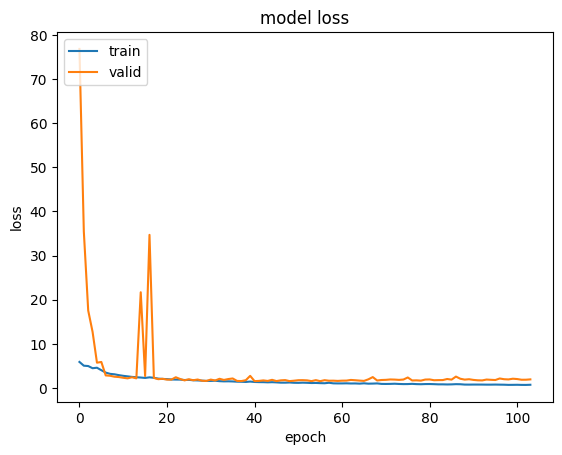

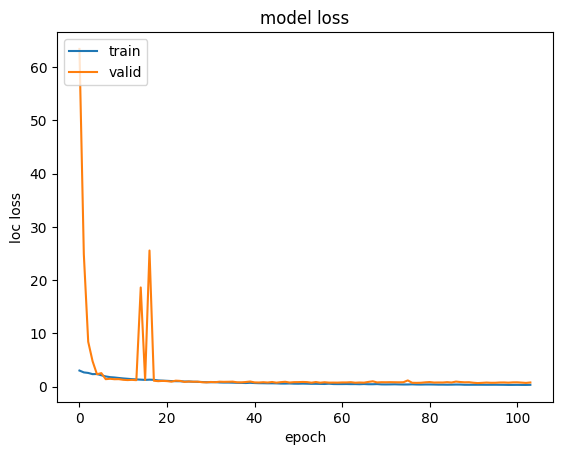

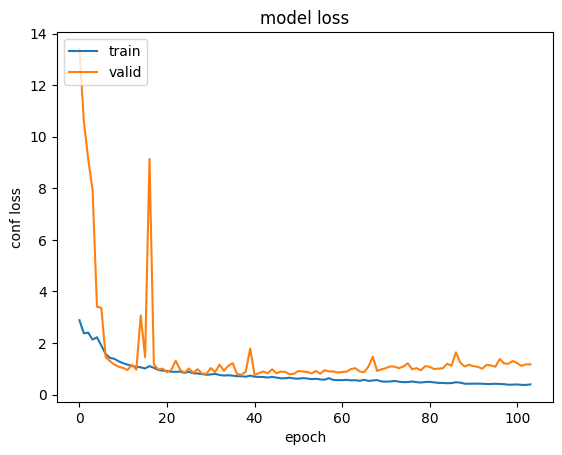

In [27]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loc_loss'])
plt.plot(history.history['val_loc_loss'])
plt.title('model loss')
plt.ylabel('loc loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.figure(3)
plt.plot(history.history['conf_loss'])
plt.plot(history.history['val_conf_loss'])
plt.title('model loss')
plt.ylabel('conf loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

Text(0.5, 0, 'epoch')

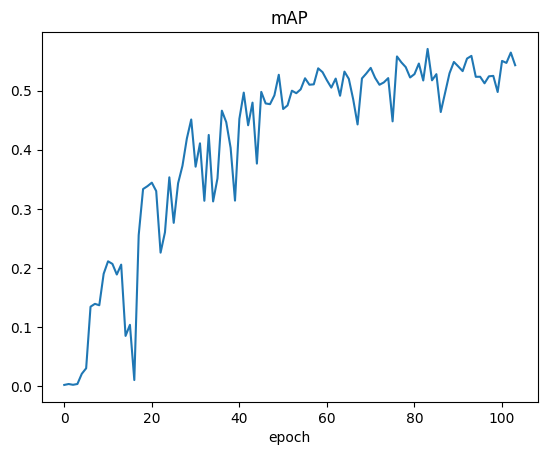

In [28]:
mAP_values = mAP_callback.get_mAP_values()
plt.plot(mAP_values)
plt.title('mAP')
plt.xlabel('epoch')

In [29]:
import glob

logs = os.listdir(f"/kaggle/working/logs/{backbone}/")
logs.sort()
log_path = f"/kaggle/working/logs/{backbone}/{logs[-1]}"
print(log_path)

/kaggle/working/logs/mobilenet_v2/20240323-155121


# predictor (test mAP + FPS)

In [30]:
evaluate = True
use_custom_images = False
custom_image_path = "data/images/"

test_data, total_items = tfr_dataset(test_files)
print(total_items)

data_types = get_data_types()
data_shapes = get_data_shapes()
padding_values = get_padding_values()

if use_custom_images:
    img_paths = get_custom_imgs(custom_image_path)
    total_items = len(img_paths)
    test_data = tf.data.Dataset.from_generator(lambda: custom_data_generator(
                                               img_paths, img_size, img_size), data_types, data_shapes)
else:
    test_data = test_data.map(lambda x : tfr_preprocessing(x, img_size, img_size))

test_data = test_data.padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)

116


In [31]:
import time

ssd_model = get_model(hyper_params)
ssd_model_path = get_model_path(backbone)
ssd_model.load_weights(ssd_model_path)
ssd_decoder_model = get_decoder_model(ssd_model, prior_boxes, hyper_params)

step_size = get_step_size(total_items, batch_size)

start_time = time.time()
pred_bboxes, pred_labels, pred_scores = ssd_decoder_model.predict(test_data, steps=step_size, verbose=1)
end_time = time.time()
total_time_taken = end_time - start_time

# Calculate Frames Per Second (FPS)
fps = total_items / total_time_taken

# Print the results
print(f"Total time taken: {total_time_taken} seconds")
print(f"Frames Per Second (FPS): {fps}")

if evaluate:
    stats, mAP = evaluate_predictions(test_data, pred_bboxes, pred_labels, pred_scores, labels, batch_size)
else:
    draw_predictions(test_data, pred_bboxes, pred_labels, pred_scores, labels, batch_size)

15/15 [==============================] - 2s 67ms/step
Total time taken: 2.207273006439209 seconds
Frames Per Second (FPS): 52.55353536313669
mAP: 0.6071527220248436


In [32]:
for i in stats:
    print(stats[i]['label'])
    print('Total:', stats[i]['total'])
    print('Total Predictions', len(stats[i]['tp']))
    print('Correct Predictions:', stats[i]['tp'].count(1))

Hole
Total: 47
Total Predictions 121
Correct Predictions: 42
Knot
Total: 25
Total Predictions 104
Correct Predictions: 19
Line
Total: 36
Total Predictions 79
Correct Predictions: 15
Stain
Total: 46
Total Predictions 131
Correct Predictions: 40


In [33]:
stats

{1: {'label': 'Hole',
  'total': 47,
  'tp': [0,
   1,
   0,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   1,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   1,
   0,
   1,
   1,
   1,
   0,
   0,
   1,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   1,
   1,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   1,
   0,
   0,
   0],
  'fp': [1,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
  

In [34]:
# draw_predictions(test_data, pred_bboxes, pred_labels, pred_scores, labels, batch_size)